In [1]:
from tint.grid_utils import *
from tint_cases import *
from tint.objects import *
%matplotlib inline


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



In [40]:
#Define times and radar ID

rid="71"
#times=[dt.datetime(2010,8,2,15,40),dt.datetime(2010,8,2,15,45)]
#times=[dt.datetime(2013,2,23,13,40),dt.datetime(2013,2,23,13,45)]
times=[dt.datetime(2013,10,29,3,5),dt.datetime(2013,10,29,3,8)]
#times=[dt.datetime(2015,12,16,2,0),dt.datetime(2015,12,16,2,5)]
#times=[dt.datetime(2016,6,4,3,36),dt.datetime(2016,6,4,3,42)]
#times=[dt.datetime(2017,4,9,8,0),dt.datetime(2017,4,9,8,6)]

#rid="2"
#times=[dt.datetime(2010,3,6,3,27),dt.datetime(2010,3,6,3,33)]
#times=[dt.datetime(2011,12,25,6,42),dt.datetime(2011,12,25,6,48)]
#times=[dt.datetime(2013,3,21,3,39),dt.datetime(2013,3,21,3,45)]


# rid="50"
# times=[dt.datetime(2018,2,13,7,0),dt.datetime(2018,2,13,7,4)]

#rid="27"
#times=[dt.datetime(2014,10,31,7,45),dt.datetime(2014,10,31,7,55)]
#times=[dt.datetime(2017,12,18,11,25),dt.datetime(2017,12,18,11,35)]
#times=[dt.datetime(2010,12,7,9,15),dt.datetime(2010,12,7,9,25)]

In [41]:
#Load the radar data into a pyart grid object. This would go into TINT (see tint_driver.py)

outname = rid+"_"+times[0].strftime("%Y%m%d")
unpack_level1b(rid, times)
grid_files = np.sort(glob.glob("/scratch/w40/ab4502/tint/"+rid+"*_grid.nc"))
file_dates = np.array([dt.datetime.strptime(f.split("/")[5].split("_")[1] + f.split("/")[5].split("_")[2],\
                "%Y%m%d%H%M%S") for f in grid_files])
target_files = grid_files[(file_dates >= times[0]) & (file_dates <= times[1])]

grid_obj=pyart.io.read_grid(target_files[0])

In [42]:
#Define the TINT settings, as in tint_driver.py

refl_name="corrected_reflectivity";tracks_obj = Cell_tracks(refl_name)
tracks_obj.params["FIELD_THRESH"]=30
tracks_obj.params["MIN_SIZE"]=15
tracks_obj.params["MIN_VOL"]=30
tracks_obj.params["MIN_HGT"]=2
tracks_obj.params["MAX_DISPARITY"]=60
tracks_obj.params["SEARCH_MARGIN"]=10000
tracks_obj.params["SKIMAGE_PROPS"]=["eccentricity","major_axis_length","minor_axis_length","bbox"]
tracks_obj.params["FIELD_DEPTH"]=5
tracks_obj.params["LOCAL_MAX_DIST"]=4
tracks_obj.params["AZI_SHEAR"]=True
tracks_obj.params["STEINER"]=False
tracks_obj.params["AZH1"]=2
tracks_obj.params["AZH2"]=6
tracks_obj.params["SEGMENTATION_METHOD"]="watershed"
tracks_obj.params["WATERSHED_THRESH"]=[30]
tracks_obj.params["WATERSHED_SMOOTHING"]=3
tracks_obj.params["WATERSHED_EROSION"]=0
tracks_obj.params["MIN_FIELD"]=30

params=tracks_obj.params

In [43]:
#Set up data and thresholds for extract_grid_data() in tint.grid_utils. This is where segmentation is done

grid_size = get_grid_size(grid_obj)
field = tracks_obj.field
min_size = params['MIN_SIZE'] / np.prod(grid_size[1:]/1000)
min_vol = params['MIN_VOL'] / np.prod(grid_size/1000)
min_height = params['MIN_HGT'] / np.prod(grid_size[0]/1000)
masked = grid_obj.fields[field]['data']
#masked.data[masked.data == masked.fill_value] = 0
masked[masked.mask] = 0
gs_alt = params['GS_ALT']
raw = masked.data[get_grid_alt(grid_size, gs_alt), :, :]

In [44]:
#Do the tobac segmentation

colmax = grid_obj.to_xarray()[field].max("z")
for n in colmax.coords:
    if n not in ["time","x","y"]:
        colmax = colmax.drop(n)
colmax = colmax.where(~colmax.isnull(),0).to_iris()

parameters_features={}
parameters_segmentation={}
parameters_features['position_threshold']='extreme'
parameters_features['sigma_threshold']=tracks_obj.params["WATERSHED_SMOOTHING"]
parameters_features['threshold']=tracks_obj.params["WATERSHED_THRESH"]
parameters_features['n_erosion_threshold']=tracks_obj.params["WATERSHED_EROSION"]
parameters_segmentation['threshold']=tracks_obj.params["FIELD_THRESH"]
parameters_segmentation['sigma_threshold']=params["WATERSHED_SMOOTHING"]

Features=tobac.feature_detection.feature_detection_multithreshold(colmax,grid_size[1],**parameters_features)
Mask_refl,Features=tobac.segmentation.segmentation(Features,colmax,grid_size[1],**parameters_segmentation)
frame=clear_small_echoes(Mask_refl.data, masked.data, min_size, min_vol, min_height, params['FIELD_THRESH'], params["MIN_FIELD"])

Text(0.5, 1.0, 'Segmentation and removing small/weak (less than 30 dBZ max) objects')

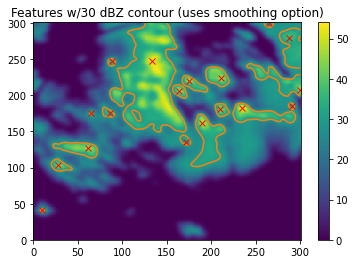

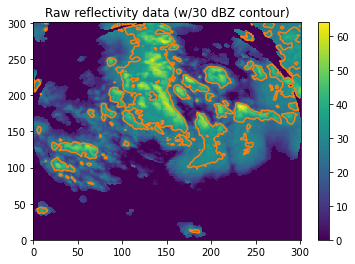

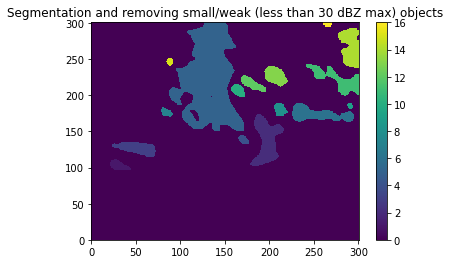

In [45]:
#Do some plots

plt.figure()
plt.pcolormesh(gaussian_filter(colmax.data[0],parameters_features['sigma_threshold'])); plt.colorbar()
plt.plot(Features.hdim_2, Features.hdim_1, ls="none",marker="x",color="red")    
plt.contour(gaussian_filter(colmax.data[0],parameters_features['sigma_threshold']),levels=[parameters_segmentation['threshold']],colors="tab:orange")   
plt.title("Features w/30 dBZ contour (uses smoothing option)")

plt.figure()
plt.pcolormesh(colmax.data[0]); plt.colorbar()
plt.contour(colmax.data[0],levels=[parameters_segmentation['threshold']],colors="tab:orange")           
plt.title("Raw reflectivity data (w/30 dBZ contour)")   
          
plt.figure()
plt.pcolormesh(frame)
plt.colorbar()
plt.title("Segmentation and removing small/weak (less than 30 dBZ max) objects")

In [32]:
grid_obj.time

{'long_name': 'Time of grid',
 'units': 'seconds since 2010-12-07T09:10:01Z',
 'standard_name': 'time',
 'calendar': 'gregorian',
 'data': masked_array(data=[0.],
              mask=False,
        fill_value=1e+20,
             dtype=float32)}

In [8]:
field_time=colmax.slices_over('time')
for i,field_i in enumerate(field_time):
    print(i,field_i)

0 corrected_reflectivity / (unknown)  (projection_y_coordinate: 301; projection_x_coordinate: 301)
    Dimension coordinates:
        projection_y_coordinate                             x                             -
        projection_x_coordinate                             -                             x
    Scalar coordinates:
        time                        2010-08-02 15:43:01
